In [8]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np

import importlib

import helper_functions.utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.publicTransit as publicTransit

# Import bus network

In [9]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

### Import planning area

<Axes: >

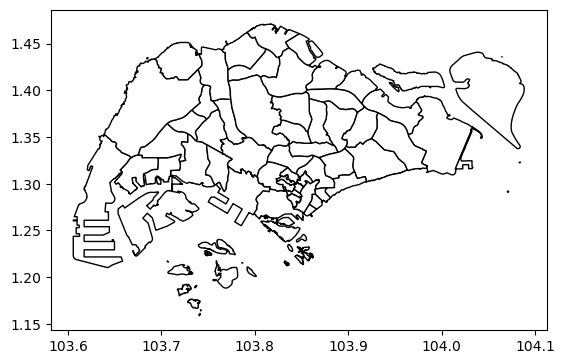

In [34]:
planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
planningArea_shp.plot(fc='white',ec='k')

### Import work cluster

In [44]:
workplace_cluster = pd.read_csv(r"data\workplace_cluster.csv")
workplace_cluster
workplace_nodes = ox.distance.nearest_nodes(G_bus, X=workplace_cluster.longitude.to_list(), Y=workplace_cluster.latitude.to_list())
workplace_nodes
workplace_cluster['node_ID'] = workplace_nodes
workplace_cluster.head()

,latitude,longitude,node_ID
0,1.320935,103.894151,258305981
1,1.327584,103.703464,4494048581
2,1.448092,103.810287,4607055587
3,1.284441,103.842959,246800416
4,1.295068,103.629310,842360753


# Import public transit json routes

In [38]:
publicTransit_dir = r"D:\PAKHUIYING\publicTransit_busRouting_busLeg_OneMap"
publicTransit_fp_list = [os.path.join(publicTransit_dir,fp) for fp in os.listdir(publicTransit_dir) if not fp.endswith('_ERROR.json')]
print(len(publicTransit_fp_list))
publicTransit_fp_list[:10]

32265


['D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01013to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01013to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01013to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01019to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01019to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01019to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01029to258305981.json']

In [39]:
# import one itinerary
itinerary = utils.load_json(publicTransit_fp_list[1])
itinerary

{'busStart': [1.29684825487647, 103.85253591654006, '01012'],
 'workEnd': [1.3275840581980238, 103.70346391036824, 4494048581],
 'duration': 3975,
 'startTime': 1738714568000,
 'endTime': 1738718543000,
 'transitTime': 3306,
 'waitingTime': 322,
 'transfers': 2,
 'busLegs': [{'leg_number': 0,
   'duration': 335,
   'distance': 1567.66,
   'startTime': 1738714568000,
   'endTime': 1738714903000,
   'tripId': '63-1-1002',
   'tripDirection': 0,
   'mode': 'BUS',
   'routeId': '63',
   'legGeometry': {'points': 'ug|F}uzxRWUgCkBIIeDcCIGIG}@o@uCaCqAcA?A??SQkByAIGwD_Ds@k@MK{CiCIGMM_A_A[]c@c@}@aACEA???cAoAoA}AsA_BGIIKeAkA??{CiDyCeD??',
    'length': 38},
   'busLeg': [{'name': 'HOTEL GRAND PACIFIC',
     'stopId': 'FERRY:01012',
     'stopCode': '01012',
     'lon': 103.8525359,
     'lat': 1.2968483,
     'departure': 1738714568000,
     'stopIndex': 69,
     'stopSequence': 71,
     'vertexType': 'TRANSIT',
     'arrival': nan},
    {'name': 'OPP BUGIS STN EXIT C',
     'stopId': 'FERRY:011

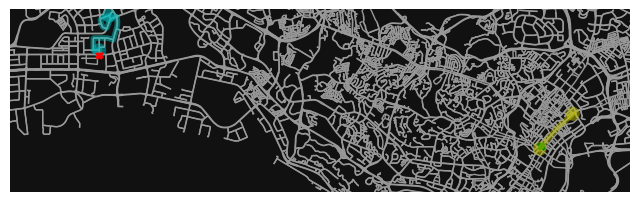

In [ ]:
TI = publicTransit.TripItinerary(G_bus, itinerary)
TI.plot_itinerary()

In [ ]:
TI = publicTransit.TripItinerary.from_file(G_bus, fp=publicTransit_fp_list[1])
itinerary_entry = TI.get_itinerary_entry()
itinerary_entry

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.3275840581980238,
 'end_lon': 103.70346391036824,
 'actual_bus_duration': 1017.0,
 'simulated_bus_duration': 358,
 'actual_bus_distance': 5171.84,
 'simulated_bus_distance': 5542,
 'actual_total_duration': 3975.0,
 'simulated_total_duration': 3316.0,
 'non_bus_duration': 2958.0,
 'number_of_busroutes': 2}

In [ ]:
noData_file = os.path.join(r'data','error_itineraryEntry_log1.txt')
itinerary_entries = []
for fp in publicTransit_fp_list:
    TI = publicTransit.TripItinerary.from_file(G_bus, fp=fp)
    try:
        itinerary_entry = TI.get_itinerary_entry()
        itinerary_entries.append(itinerary_entry)
    except:
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{fp}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{fp}\n')

itinerary_df = pd.DataFrame.from_records(itinerary_entries)
# append notes ID to the start and end coordinates
itinerary_df['start_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['start_lon'], Y = itinerary_df['start_lat'])
itinerary_df['end_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['end_lon'], Y = itinerary_df['end_lat'])
# itinerary_df.to_csv(os.path.join(r"data","bus_routing_OneMap.csv"),index=False)
itinerary_df.head()

,start_lat,start_lon,end_lat,end_lon,actual_bus_duration,simulated_bus_duration,actual_bus_distance,simulated_bus_distance,actual_total_duration,simulated_total_duration,non_bus_duration,number_of_busroutes,start_nodesID,end_nodesID
0,1.296848,103.852536,1.320935,103.894151,87.0,52,624.40,871,1297.0,1262.0,1210.0,1,4748705954,258305981
1,1.296848,103.852536,1.327584,103.703464,1017.0,358,5171.84,5542,3975.0,3316.0,2958.0,2,4748705954,4494048581
2,1.296848,103.852536,1.448092,103.810287,1168.0,347,5460.83,5042,4668.0,3847.0,3500.0,2,4748705954,4607055587
3,1.297710,103.853225,1.320935,103.894151,306.0,94,1444.11,1574,1370.0,1158.0,1064.0,1,4738400701,258305981
4,1.297710,103.853225,1.327584,103.703464,740.0,288,4105.07,4367,3629.0,3177.0,2889.0,2,4738400701,4494048581


Split itinerary based on unique end nodes e.g. end_nodesID

In [45]:
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
print(len(set(itinerary_master_df['end_nodesID'])))
print(itinerary_master_df.dtypes)
itinerary_df_list = {k:df for k,df in itinerary_master_df.groupby('end_nodesID')}
print(len(list(itinerary_df_list)))

12
start_lat                   float64
start_lon                   float64
end_lat                     float64
end_lon                     float64
actual_bus_duration         float64
simulated_bus_duration        int64
actual_bus_distance         float64
simulated_bus_distance        int64
actual_total_duration       float64
simulated_total_duration    float64
non_bus_duration            float64
number_of_busroutes           int64
start_nodesID                 int64
end_nodesID                   int64
dtype: object
12


In [49]:
# check if there are workplace nodes not in itinerary df
print(set(list(itinerary_df_list))^set(workplace_cluster['node_ID']))
workplace_cluster.dtypes

set()


latitude     float64
longitude    float64
node_ID        int64
dtype: object

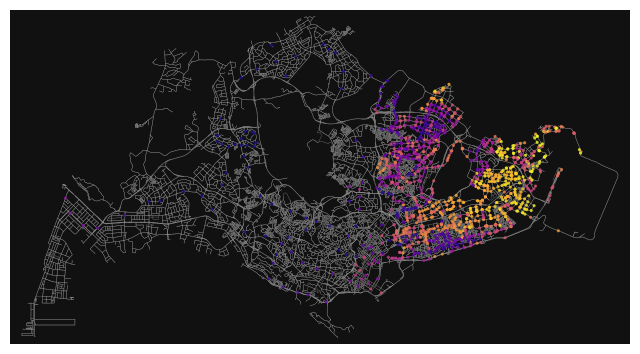

In [50]:
def plot_shortest_path_publicTransit(G, itinerary_df,ax=None,
                                cmap="plasma",cbar=None,node_size=5):
    """ 
    Args:
        G (MultiDiGraph): graph of car network
        itinerary_df (pd.DataFrame): df with columns that describes the simulated or actual time
        cmap (str): cmap for colouring the isochrones
        cbar (ScalarMappable or None): if None, use cmap to automatically generate unique colours based on number of nodes. Else, use cbar to map values to colours
        node_size (float): size of notes for plotting
    Returns:
         
    """
    # create a dict where key are start_nodesID, and values are route times
    route_times = itinerary_df[['start_nodesID','simulated_total_duration']].set_index('start_nodesID').to_dict()
    route_times = route_times['simulated_total_duration']
    # sort dict based on the value i.e. route times
    route_times = {k: v for k, v in sorted(route_times.items(), key=lambda item: item[1])}
    # route_times = itinerary_df['simulated_total_duration'].sort_values()
    if cbar is None:
        iso_colors = ox.plot.get_colors(n=len(route_times), cmap=cmap, start=0)
    else:
        iso_colors = [mpl.colors.rgb2hex(cbar.to_rgba(i),keep_alpha=True) for i in route_times.values()]
    node_colors = {node: nc_ for node, nc_ in zip(list(route_times),iso_colors)}
    nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes() ]
    ns = [node_size if node in node_colors else 0 for node in G.nodes()]
    fig, ax = ox.plot_graph(
        G,
        ax=ax,
        node_color=nc,
        node_size=ns,
        node_alpha=0.8,
        edge_linewidth=0.2,
        edge_color="#999999",
        show = False,
        close = False
    )
    return route_times

route_times = plot_shortest_path_publicTransit(G_bus, itinerary_df_list[list(itinerary_df_list)[0]])

In [55]:
itinerary_master_df[itinerary_master_df['number_of_busroutes']>0].sort_values('simulated_total_duration').tail()

,start_lat,start_lon,end_lat,end_lon,actual_bus_duration,simulated_bus_duration,actual_bus_distance,simulated_bus_distance,actual_total_duration,simulated_total_duration,non_bus_duration,number_of_busroutes,start_nodesID,end_nodesID
16850,1.410714,103.861884,1.295068,103.62931,2744.0,975,14805.71,15213,10996.0,9227.0,8252.0,2,5184268821,842360753
16838,1.410769,103.861795,1.295068,103.62931,2744.0,975,14805.71,15213,11054.0,9285.0,8310.0,2,5184268821,842360753
16910,1.402289,103.859630,1.295068,103.62931,2744.0,975,14805.71,15213,11055.0,9286.0,8311.0,2,1781710564,842360753
16898,1.403739,103.858254,1.295068,103.62931,2708.0,1056,16223.29,16648,10989.0,9337.0,8281.0,2,6799293231,842360753
16886,1.404070,103.858281,1.295068,103.62931,2708.0,1056,16223.29,16648,10998.0,9346.0,8290.0,2,6799293231,842360753


# Plot itineraries 
- Only itineraries with at least 1 bus route is plotted
- Each subplot represents itinerary to a unique work cluster

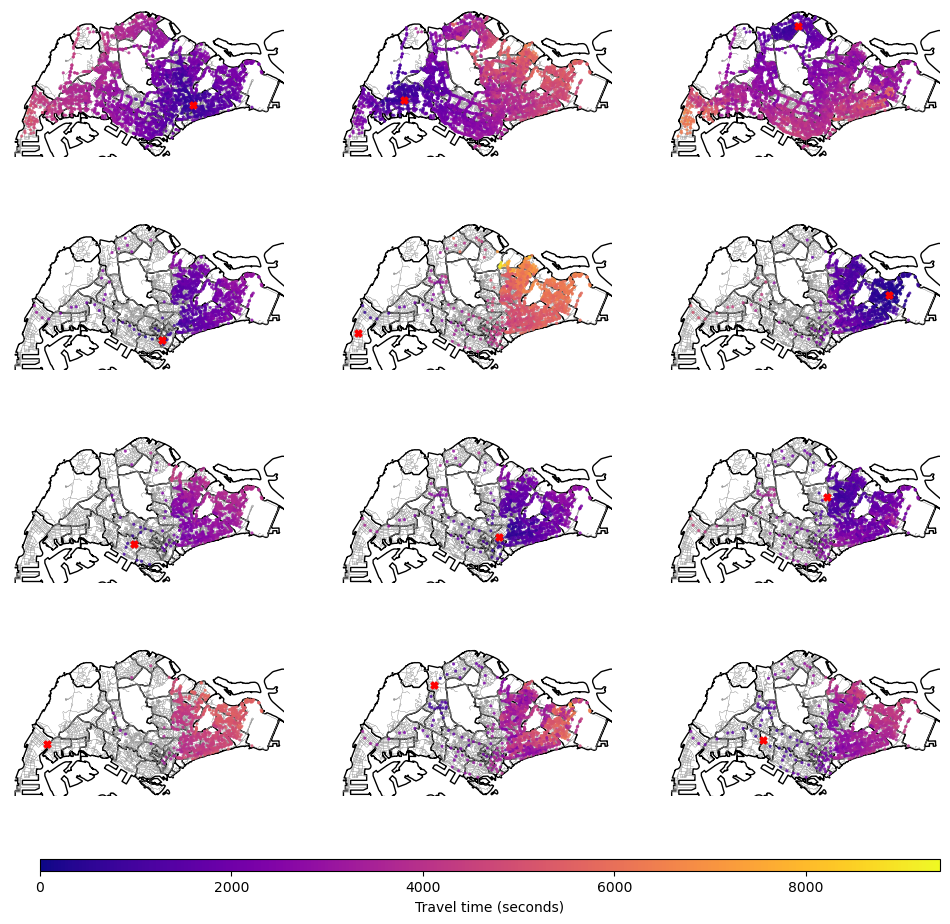

In [56]:
iso_dir = os.path.join(r"data","isochrones")
if not os.path.exists(iso_dir):
    os.mkdir(iso_dir)
n_clusters = len(workplace_cluster.index)
ncols = 3
nrows = n_clusters//ncols
# define cbar 
cbar = plot_utils.get_colorbar(vmin=0,vmax=9400,cmap="plasma",plot=False)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols*4,nrows*3))
for i, ax in enumerate(axes.flatten()):
    # plot planning area boundary
    planningArea_shp.plot(fc='white',ec='k',ax=ax)
    # get attributes
    lat = workplace_cluster.loc[i,"latitude"]
    lon = workplace_cluster.loc[i,"longitude"]
    node_id = workplace_cluster.loc[i,"node_ID"]
    # extract itinerary based on work place node_id
    itinerary_df = itinerary_df_list[node_id]
    # remove itineraries where there are no bus routes
    itinerary_df = itinerary_df[itinerary_df['number_of_busroutes']>0]
    # plot isochrone
    plot_shortest_path_publicTransit(G_bus, itinerary_df,cbar=cbar,ax=ax)
    # plot orig node
    ax.scatter(lon,lat,marker="X",c="r",s=25)
# plt.tight_layout()
# plot colorbar
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.75, 0.01]) # left, bottom, width, height
fig.colorbar(cbar, cax=cbar_ax, orientation='horizontal', label='Travel time (seconds)')
fp_save = os.path.join(iso_dir,"dry_isochrone_publicTransit_workClusters.png")
plt.savefig(fp_save, bbox_inches = 'tight')
plt.show()